In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from xgboost import XGBRegressor, plot_tree

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

import graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz

from google.colab import drive

plt.rcParams['figure.figsize'] = [10, 6]
sns.set_style("dark")

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df = pd.read_csv("/content/drive/MyDrive/ORIE_5741_Final_Project/dataset.csv")

In [6]:
num_duplicates = df.duplicated('track_id').sum()
print("Number of duplicate track IDs:", num_duplicates)

# Drop rows with duplicate track IDs
df.drop_duplicates('track_id', inplace=True)

print("Number of unique track IDs after dropping duplicates:", len(df))

Number of duplicate track IDs: 24259
Number of unique track IDs after dropping duplicates: 89741


In [7]:
# Handpicked Genre to category mapping to shrink genre variety
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music',
    'house': 'Electronic Dance Music',
    'electro': 'Electronic Dance Music',
    'trance': 'Electronic Dance Music',
    'techno': 'Electronic Dance Music',
    'dubstep': 'Electronic Dance Music',
    'drum-and-bass': 'Electronic Dance Music',
    'deep-house': 'Electronic Dance Music',
    'detroit-techno': 'Electronic Dance Music',
    'minimal-techno': 'Electronic Dance Music',
    'progressive-house': 'Electronic Dance Music',
    'breakbeat': 'Electronic Dance Music',
    'electronic': 'Electronic Dance Music',
    'party': 'Electronic Dance Music',
    'chicago-house': 'Electronic Dance Music',

    # Rock
    'alt-rock': 'Rock',
    'rock': 'Rock',
    'indie': 'Rock',
    'indie-pop': 'Rock',
    'punk': 'Rock',
    'punk-rock': 'Rock',
    'hard-rock': 'Rock',
    'metal': 'Rock',
    'heavy-metal': 'Rock',
    'black-metal': 'Rock',
    'death-metal': 'Rock',
    'grunge': 'Rock',
    'rock-n-roll': 'Rock',
    'j-rock': 'Rock',
    'psych-rock': 'Rock',
    'rockabilly': 'Rock',
    'metalcore': 'Rock',


    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B',
    'r-n-b': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',
    'chill': 'Hip-Hop and R&B',
    'trip-hop': 'Hip-Hop and R&B',


    # Pop
    'pop': 'Pop',
    'electro-pop': 'Pop',
    'synth-pop': 'Pop',
    'k-pop': 'Pop',
    'pop-film': 'Pop',
    'power-pop': 'Pop',
    'cantopop': 'Pop',
    'j-pop': 'Pop',
    'mandopop': 'Pop',
    'country': 'Pop',
    'j-dance': 'Pop',
    'j-idol': 'Pop',

    # Latin and Dance
    'latin': 'Latin & Dance',
    'reggaeton': 'Latin & Dance',
    'salsa': 'Latin & Dance',
    'samba': 'Latin & Dance',
    'reggae': 'Latin & Dance',
    'dancehall': 'Latin & Dance',
    'brazil': 'Latin & Dance',
    'sertanejo': 'Latin & Dance',
    'afrobeat': 'Latin & Dance',
    'latino': 'Latin & Dance',
    'spanish': 'Latin & Dance',
    'tango': 'Latin & Dance',
    'dance': 'Latin & Dance',

    # Funk and Disco
    'funk': 'Funk and Disco',
    'disco': 'Funk and Disco',
    'groove': 'Funk and Disco',

    # Jazz and Blues
    'bluegrass': 'Blues and Jazz',
    'blues': 'Blues and Jazz',
    'jazz': 'Blues and Jazz',
    'bluegrass': 'Blues and Jazz',
}

# Map each track to a category
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

In [8]:
# Encode each cateogry with a numerical value
category_to_num = {category:index for index, category in enumerate(df['music_category'].unique())}
music_categories = set(df['music_category'].unique())
df['music_category_index'] = df['music_category'].apply(lambda x: category_to_num.get(x, 8))

In [9]:
# Change duration to minutes
df['duration_min'] = df['duration_ms'] / 60000

# Change explicit to ints from booleans
df['explicit'] = df['explicit'].astype(int)

# Remove all popularity scores of 0, belive these songs are too old so their popularity score is irrelevant to current time
df = df[df['popularity'] != 0]

# Drop empty string values by changing them to NAN
df.replace('', np.nan, inplace=True)
df = df.dropna()

clustering_df = df.copy()

# Drop all unused data for Regression
df = df.drop(columns=['track_id', 'track_name', 'album_name', 'artists', 'Unnamed: 0', 'duration_ms'])

<ipython-input-9-4ff1c47121c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('', np.nan, inplace=True)


# Exploratory Data Analysis

In [10]:
# Make EDA dataframe for only music attributes
eda_df = df.copy()
eda_df.head(5)

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,music_category,music_category_index,duration_min
0,73,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,Other,0,3.844433
1,55,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,Other,0,2.493500
2,57,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,Other,0,3.513767
3,71,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,Other,0,3.365550
4,82,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,Other,0,3.314217


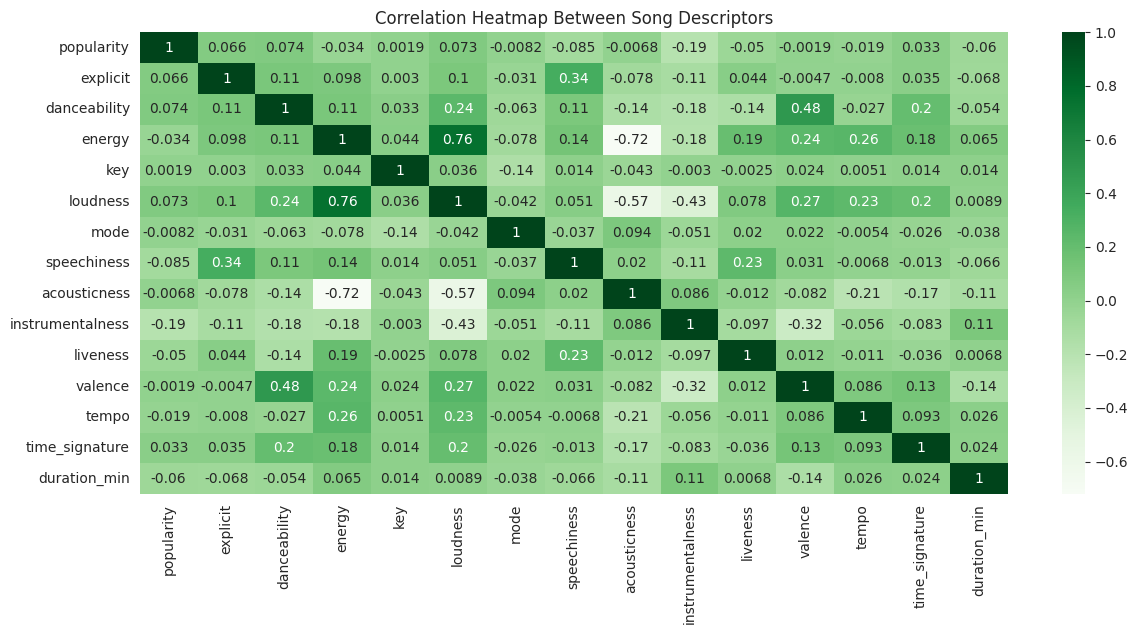

In [11]:
# Correlation Map
corr_df = eda_df.drop(columns=['track_genre', 'music_category', 'music_category_index'])
corr_df = corr_df.corr(method="pearson")
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(data=corr_df, annot=True, cmap="Greens")
heatmap.set_title("Correlation Heatmap Between Song Descriptors")
plt.show()

In [12]:
def my_histplot(df, col, ax):
    sns.histplot(df[col], ax=ax, color="green", kde=True)
    ax.set_title(f'Distribution of {col}')

def plot_charts(df, plot_func, size=(12, 5), n_col=1):
    if len(df.columns) == 0:
        return
    n_rows = (len(df.columns) + n_col-1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(df.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, label in enumerate(df.columns):
        plot_func(df, label, axes[i])
        axes[i].set_xlabel(label)

    for j in range(i+1, n_rows*n_col):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

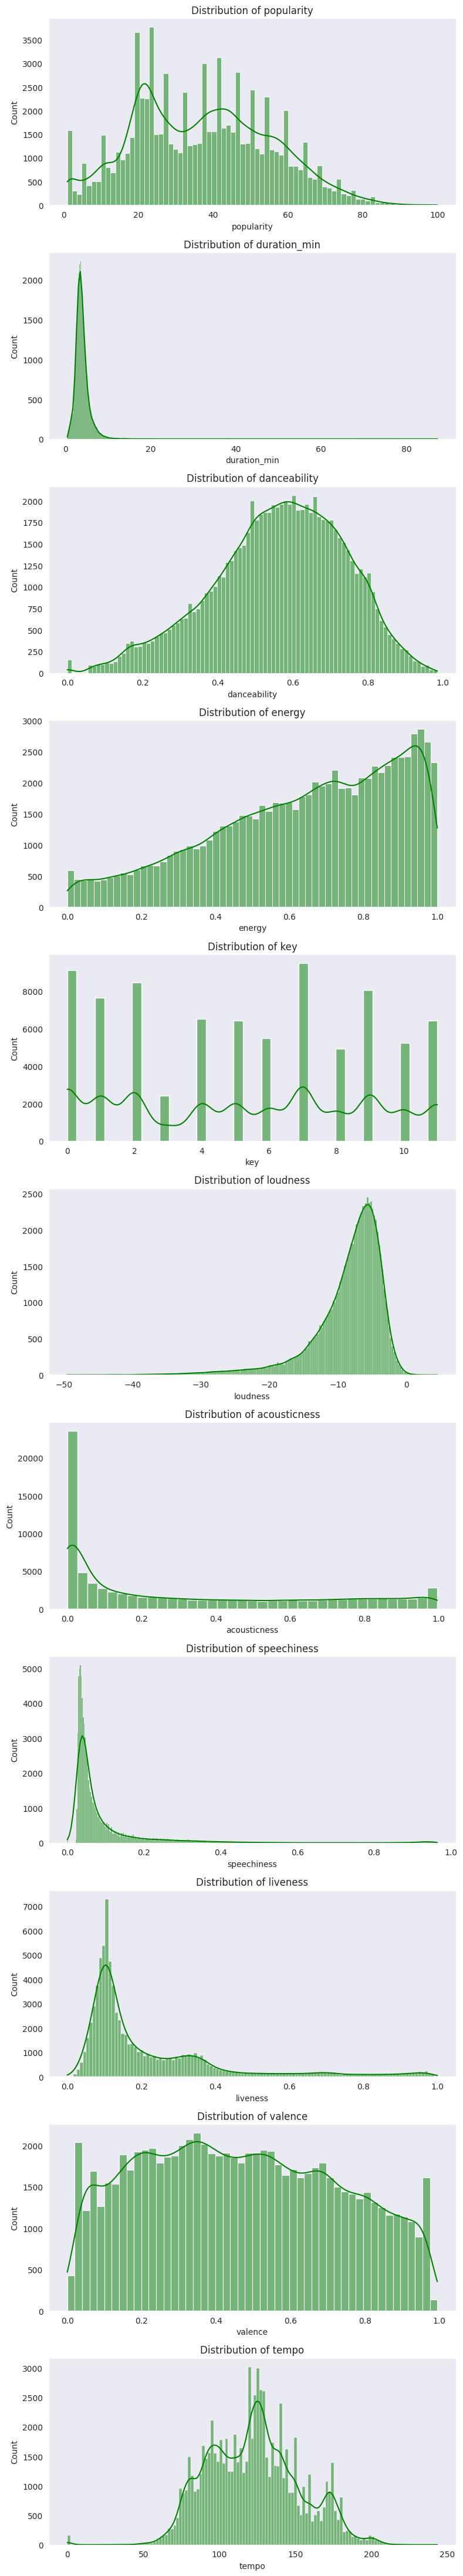

In [13]:
selected_columns = ['popularity', 'duration_min', 'danceability', 'energy', 'key', 'loudness', 'acousticness', 'speechiness', 'liveness', 'valence', 'tempo' ]
plot_charts(eda_df[selected_columns], my_histplot, size=(8, 4))

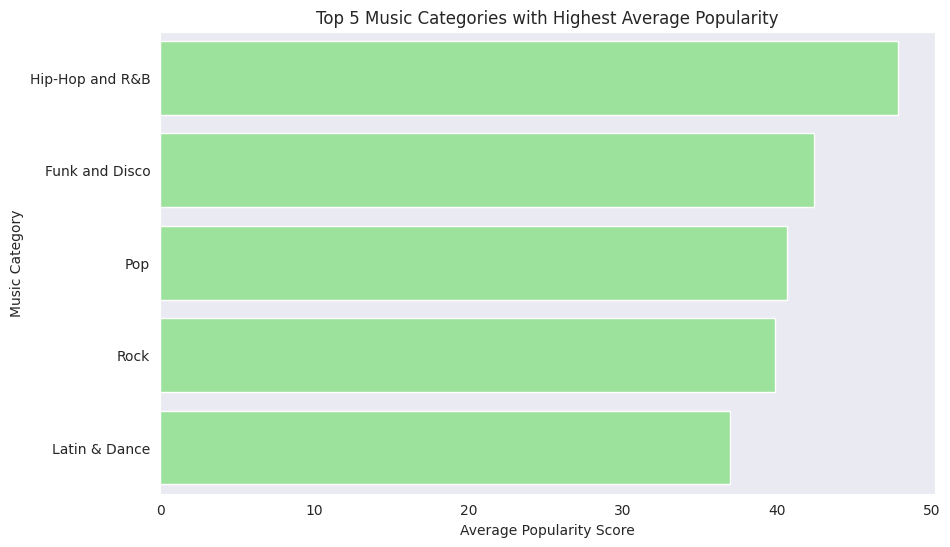

From this, we find that the top 5 most popular categories are: ['Hip-Hop and R&B', 'Funk and Disco', 'Pop', 'Rock', 'Latin & Dance']


In [14]:
# Top 10 Genres by average popularity
avg_popularity_by_category = eda_df.groupby('music_category')['popularity'].mean().reset_index()
top5_popular_cats = avg_popularity_by_category.nlargest(5, 'popularity')

plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='music_category', data=top5_popular_cats, color='lightgreen')
plt.title('Top 5 Music Categories with Highest Average Popularity')
plt.xlabel('Average Popularity Score')
plt.ylabel('Music Category')
plt.show()

top5_cats = list(top5_popular_cats['music_category'])
print('From this, we find that the top 5 most popular categories are: {0}'.format(top5_cats))

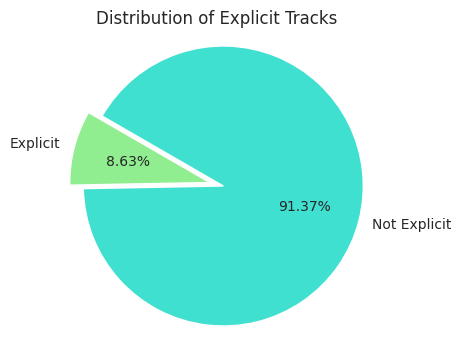

In [15]:
# Pie chart showing distribution of explicit tracks
num_to_explicit = {0 : "Not Explicit", 1 : "Explicit"}
explicit = eda_df['explicit'].apply(lambda x: num_to_explicit.get(x, 'Other'))
unique_values, value_counts = np.unique(explicit, return_counts=True)

fig, ax = plt.subplots(figsize=(4, 4))

# Explode the slice with explicit tracks for emphasis
explode = [0, 0.1]
colors = ['lightgreen', 'turquoise']

ax.pie(value_counts, labels=unique_values, autopct='%1.2f%%', startangle=150, colors=colors, explode=explode)
ax.axis('equal')
ax.set_title('Distribution of Explicit Tracks', horizontalalignment='center')
plt.show()

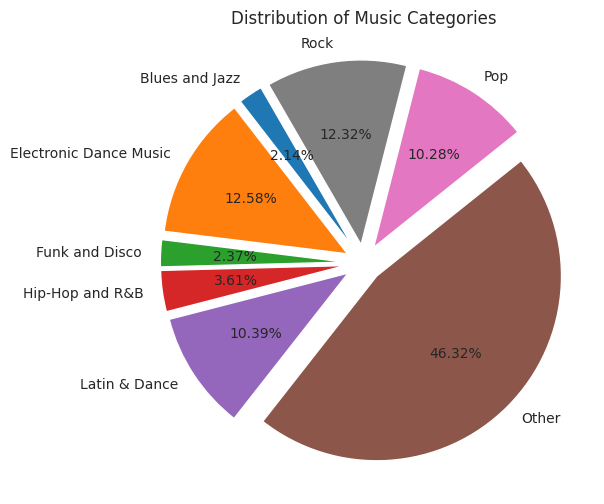

In [16]:
# Pie chart showing distribution of music categories
unique_values, value_counts = np.unique(eda_df['music_category'], return_counts=True)

fig, ax = plt.subplots(figsize=(6, 6))

explode = [0.1] * len(unique_values)

ax.pie(value_counts, labels=unique_values, autopct='%1.2f%%', startangle=120, explode=explode)
ax.set_title('Distribution of Music Categories', horizontalalignment='center', verticalalignment= 'baseline')
plt.show()

# Regression

In [17]:
# Save regression df
regression_df = df.copy()

In [18]:
regression_df.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,music_category,music_category_index,duration_min
0,73,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,Other,0,3.844433
1,55,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,Other,0,2.493500
2,57,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,Other,0,3.513767
3,71,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,Other,0,3.365550
4,82,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,Other,0,3.314217


In [19]:
X = regression_df.drop(['popularity', 'track_genre', 'music_category'], axis=1)
y = regression_df['popularity']

X_scaled = StandardScaler().fit_transform(X)

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_x_scaled, test_x_sclaed, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)
train_x_scaled = train_x.reset_index(drop=True)
test_x_scaled = test_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [20]:
# Trying multiple Regression Models to see which performs the best
lin_model = LinearRegression()
ridge_model = Ridge(alpha=.1)
lasso_model = Lasso(alpha=.1)

tr = DecisionTreeRegressor()
xgboostreg = XGBRegressor()

poly_list = [PolynomialFeatures(degree=i, include_bias=False) for i in range(2,4)]
prm_list = [LinearRegression() for i in range(2,4)]

In [21]:
def poly_metrics(models, poly_list, X_test, y_test, decimals = 5, X_train = train_x, y_train = train_y):
    metrics_list = []
    for i in range(len(models)):
        poly_features = poly_list[i].fit_transform(X_train)
        models[i].fit(poly_features, y_train)
        y_pred = models[i].predict(poly_list[i].fit_transform(X_test))
        mse = np.round(mean_squared_error(y_test, y_pred), decimals)
        r2 = np.round(r2_score(y_test, y_pred), decimals)
        metrics_list.append(
            {'mean_squared_error': mse, 'R-Squared': r2})

    poly_df = pd.DataFrame(
        [
            {'mean_squared_error': metrics['mean_squared_error'], 'R-Squared': metrics['R-Squared']}
            for metrics in metrics_list
        ],
        index = [f'Polynomial Regression {i+2} degrees' for i in range(len(metrics_list))]).reset_index().rename(columns = {'index': 'model'})

    return poly_df

In [22]:
poly_df = poly_metrics(prm_list, poly_list, test_x, test_y)

In [23]:
def model_metrics(model, X_test, y_test, decimals = 5, X_train = train_x, y_train = train_y):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.round(mean_squared_error(y_test, y_pred),decimals)
    r2 = np.round(r2_score(y_test, y_pred),decimals)

    return {'mean_squared_error': mse, 'R-Squared': r2}

reg_model_df = pd.DataFrame(
    [
        model_metrics(lin_model, test_x, test_y),
        model_metrics(ridge_model, test_x_scaled, test_y, X_train=train_x_scaled),
        model_metrics(lasso_model, test_x_scaled, test_y, X_train=train_x_scaled),
        model_metrics(tr, test_x, test_y),
        model_metrics(xgboostreg, test_x, test_y),
    ], index = ['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor', 'XGBRegressor']).reset_index().rename(columns={'index':'model'})

In [24]:
results = pd.concat([reg_model_df, poly_df], axis=0).reset_index(drop=True)
results

,model,mean_squared_error,R-Squared
0,LinearRegression,306.29426,0.08184
1,Ridge,306.29431,0.08184
2,Lasso,309.48846,0.07227
3,DecisionTreeRegressor,485.19496,-0.45444
4,XGBRegressor,257.03304,0.22951
5,Polynomial Regression 2 degrees,284.70259,0.14656
6,Polynomial Regression 3 degrees,277.22900,0.16897


In [25]:
# Best R^2 score was XGBoosted Descision Tree Regressor
y_pred = xgboostreg.predict(test_x)

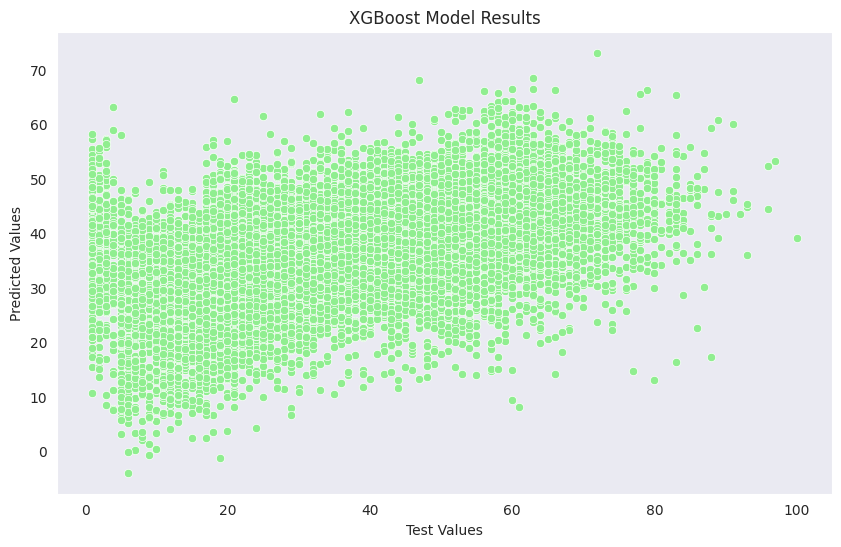

In [26]:
ax = sns.scatterplot(x=test_y, y=y_pred, color='lightgreen')
ax.set(title='XGBoost Model Results', xlabel='Test Values', ylabel='Predicted Values')
plt.show()

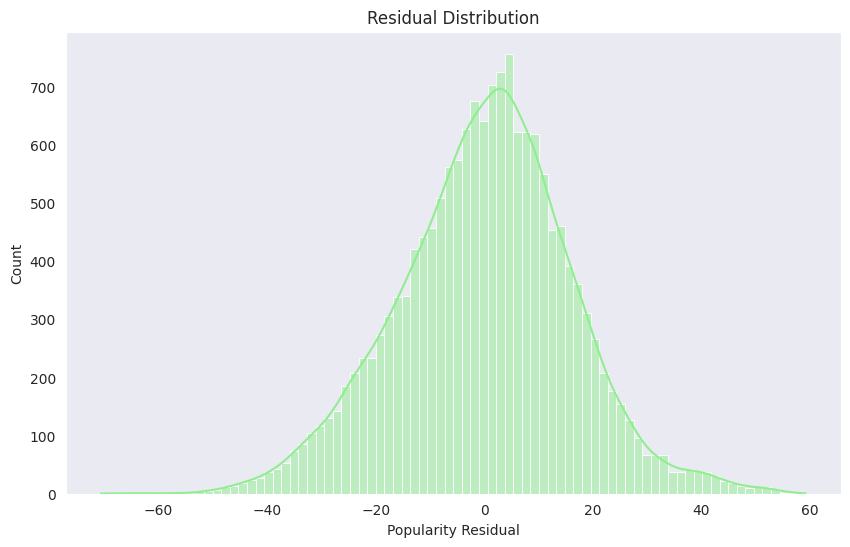

In [27]:
ax = sns.histplot(y_pred - test_y, kde = True,  color='lightgreen')
ax.set(title='Residual Distribution',  xlabel='Popularity Residual')
plt.show()

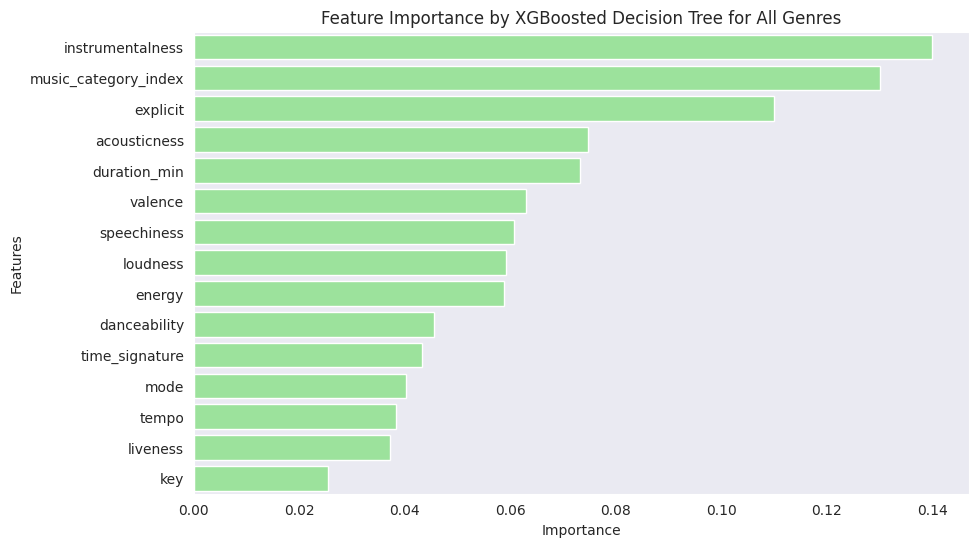

In [28]:
feature_importance = pd.DataFrame(xgboostreg.feature_importances_, index=train_x.columns, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y=feature_importance.index, data=feature_importance, color='lightgreen')
plt.title(f'Feature Importance by XGBoosted Decision Tree for All Genres')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [29]:
regression_df

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,music_category,music_category_index,duration_min
0,73,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,Other,0,3.844433
1,55,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,Other,0,2.493500
2,57,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,Other,0,3.513767
3,71,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,Other,0,3.365550
4,82,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,Other,0,3.314217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,Other,0,6.416650
113996,22,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,Other,0,6.416667
113997,22,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,Other,0,4.524433
113998,41,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,Other,0,4.731550


#Feature Importance by music categories

In [30]:
import graphviz
from sklearn.tree import export_graphviz

dt_df = regression_df.copy()

# Decision Tree for each genre in musical categories
genre_feature_importances = {}
for genre in music_categories:
    genre_data = dt_df[dt_df['music_category'] == genre]

    # Prepare data
    dropped_cols = ['track_genre', 'music_category', 'music_category_index', 'popularity']
    X_genre = genre_data.drop(dropped_cols, axis=1)
    y_genre = genre_data['popularity']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_genre, y_genre, test_size=0.2, random_state= 30)

    dt = XGBRegressor()
    dt.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame(dt.feature_importances_, index=X_genre.columns, columns=['importance']).sort_values('importance', ascending=False)
    genre_feature_importances[genre] = feature_importance

    # Visualize Decision Tree
    plot_tree(dt)
    fig = plt.gcf()
    fig.set_size_inches(150, 100)
    fig.savefig(f'tree_diagram_{genre}.svg')

    # Plot feature importance
    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y=feature_importance.index, data=feature_importance)
    plt.title(f'Feature Importance by Decision Tree for Genre: {genre}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Compare feature importance across genres
fig, ax = plt.subplots(figsize=(12, 8))
for genre in music_categories:
    imp_df = genre_feature_importances[genre]
    sns.lineplot(data=imp_df['importance'].reset_index(), x='index', y='importance', label=genre, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Comparing Feature Importance Across Genres')
ax.set_ylabel('Importance')
ax.set_xlabel('Features')

plt.legend(title='Genre')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# KNN Clustering (Song Recommendation)

In [31]:
# Reset dataframe for this task
df = pd.read_csv("/content/drive/MyDrive/ORIE_5741_Final_Project/dataset.csv")

del df['Unnamed: 0']

# Remove empty data
df.replace('', np.nan, inplace=True)
df = df.dropna()

# Remove duplicate rows
duplicate_rows_count = df.duplicated(subset=['track_id']).sum()
if duplicate_rows_count > 0:
    df = df.drop_duplicates(subset=['track_id'])

duplicate_rows_count = df.duplicated().sum()
if duplicate_rows_count > 0:
    df = df.drop_duplicates()

# Drop 0 popularity
df = df[df['popularity'] != 0]

df = df.reset_index(drop=True)

# Make a copy
kmeans_df = df.copy()

# Remove non-numerical data, True-False conversion
kmeans_df = kmeans_df.drop(['track_id', 'artists', 'album_name'], axis=1)
kmeans_df['explicit'] = kmeans_df['explicit'].apply(lambda x: 1 if x else 0)

kmeans_df.head(5)

,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [32]:
# Create list of unique genres
genres = list(kmeans_df['track_genre'].unique())
genre_encoding = {}
for i, g in enumerate(genres):
    genre_encoding[g] = i

kmeans_df['track_genre'] = kmeans_df['track_genre'].apply(lambda x: genre_encoding[x])

# Drop track names and popularity score since it doesn't give more information about similar songs
kmeans_df = kmeans_df.drop(['track_name', 'popularity'], axis=1)

# Scale features
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(kmeans_df)

# KNN initialization - n_neigbors = [# songs to recommend] + 1 (for reference song)
knn = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean')
knn.fit(kmeans_scaled)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [33]:
# Function to come up with recommendations
def recommend_song(song_id, data, kmeans_df, num_recommendations=5):
    song_indices = data[data['track_id'] == song_id].index
    artist = data.iloc[song_indices]['artists'].values[0]
    genre = data.iloc[song_indices]['track_genre'].values[0]
    data = data[(data['artists'] == artist) | (data['track_genre'] == genre)]

    data = data.reset_index(drop=True)

    kmeans_df = kmeans_df.iloc[list(data.index) - song_indices]
    # Scale features
    scaler = StandardScaler()
    kmeans_scaled = scaler.fit_transform(kmeans_df)

    # KNN initialization - n_neigbors = [# songs to recommend] + 1 (for reference song)
    knn = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='cosine')
    knn.fit(kmeans_scaled)

    song_indices = data[data['track_id'] == song_id].index

    if not song_indices.empty:
        song_index = song_indices[0]

        # Find the indices of and distances to the nearest neighbors of the song
        distances, indices = knn.kneighbors([kmeans_scaled[song_index]])

        # Get recommended song indices (excluding the query song itself)
        recommended_indices = indices[0][1:num_recommendations+1]

        # Fetch the song details based on the indices
        recommended_songs = data.iloc[recommended_indices][['track_name', 'artists']]
        songs, artists = list(recommended_songs['track_name']), list(recommended_songs['artists'])
        recs = list(map(lambda x: x[0] + ' by ' + x[1], list(zip(songs, artists))))
        return recs
    else:
        return "Song not found in dataset"

In [34]:
# Testing recommendation
# Song Name is A Drug From God by Chris Lake
song_id= "4skbQNtyjy8A7mo8oqe2oD"
recommended_songs = recommend_song(song_id, df, kmeans_df)
print('Recommended Songs:', recommended_songs)

Recommended Songs: ['Rivers by Thomas Jack', 'Middle by Noizu', 'Ferrari by James Hype;Miggy Dela Rosa', 'Back to Life by HUGEL', 'Miracle Maker by Dom Dolla;Clementine Douglas']


In [35]:
# Incorporate PCA because KNN works in multi-dimensional space -> have to reduce dimensionality
pca = PCA(n_components=2)
kmeans_pca = pca.fit_transform(kmeans_scaled)

In [36]:
# Visualizing clusters
def plot_knn(song_id, data):
    song_indices = data[data['track_id'] == song_id].index
    if not song_indices.empty:
        song_index = song_indices[0]
        distances, indices = knn.kneighbors([kmeans_scaled[song_index]])

        plt.figure(figsize=(8, 8))
        plt.scatter(kmeans_pca[:, 0], kmeans_pca[:, 1], alpha=0.1, label='All Songs', color='lightgreen')

        neighbor_indices = indices[0]
        plt.scatter(kmeans_pca[neighbor_indices, 0], kmeans_pca[neighbor_indices, 1], color='red', label='Neighbors')
        plt.scatter(kmeans_pca[song_index, 0], kmeans_pca[song_index, 1], color='black', label='Selected Song')

        plt.title('Neighbors of "{0} by {1}" in PCA Space'.format(data.iloc[song_indices]['track_name'].values[0], data.iloc[song_indices]['artists'].values[0]))
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()
    else:
        print("Song not found in the dataset.")

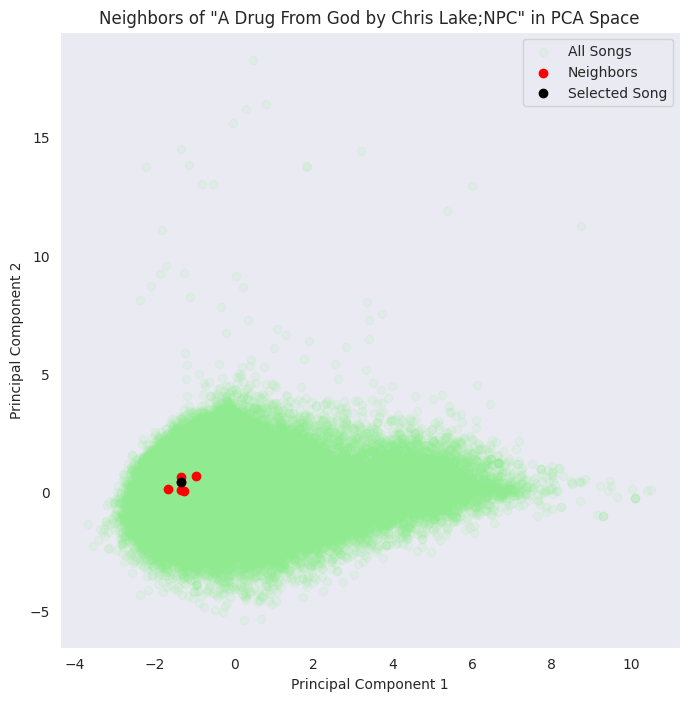

In [37]:
plot_knn(song_id, df)

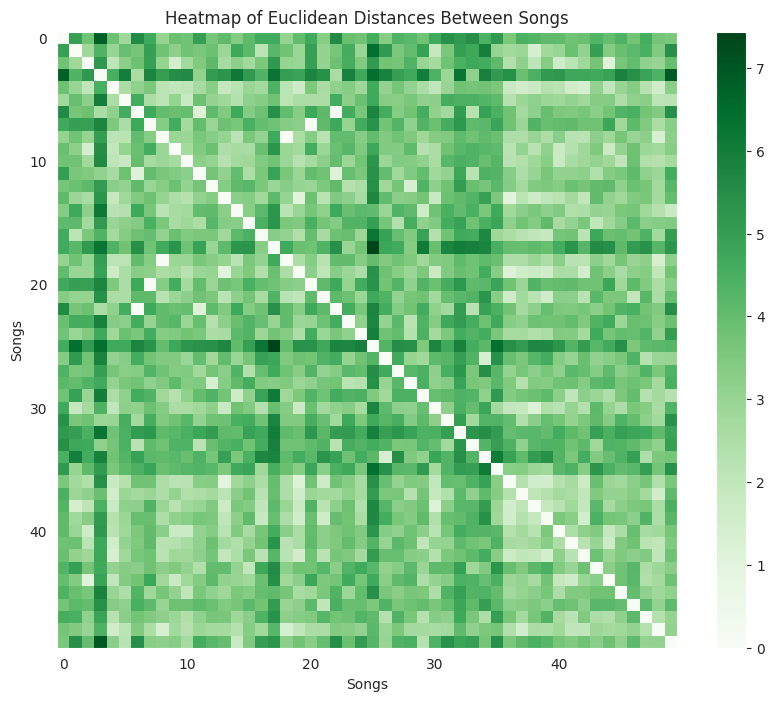

In [49]:
# Distance between songs (take first 300 songs only because size too big)
distance_matrix = euclidean_distances(kmeans_scaled[:50], kmeans_scaled[:50])
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix, aspect='auto', interpolation='nearest', cmap='Greens')
plt.colorbar()
plt.title('Heatmap of Euclidean Distances Between Songs')
plt.xlabel('Songs')
plt.ylabel('Songs')
plt.show()

In [50]:
# Interpretation: Song #25 and Song #17 are the furthest apart in terms of similarity
song_17 = clustering_df.iloc[17][['track_name', 'artists']]
song_25 = clustering_df.iloc[25][['track_name', 'artists']]

song_17 = song_17['track_name'] + ' by ' + song_17['artists']
song_25 = song_25['track_name'] + ' by ' + song_25['artists']

print('Song "{0}" and Song "{1}" are the furthest apart in terms of similarity.'.format(song_17, song_25))

Song "At My Worst by Andrew Foy;Renee Foy" and Song "透明だった世界 by Motohiro Hata" are the furthest apart in terms of similarity.
